In [122]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from category_encoders import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn_pandas import DataFrameMapper, gen_features

sns.set_style("white")

ROOT_PATH = Path("..")

In [2]:
df = pd.read_csv(ROOT_PATH / "data/raw/metadata.csv")
svc_ids = pd.read_json(ROOT_PATH / "data/raw/song_vs_call.json").squeeze()
svc_df = df.loc[df.id.isin(svc_ids)].copy()

with open(ROOT_PATH / "data/processed/svc_split.json") as svc_split_file:
    svc_split = json.load(svc_split_file)
    train_ids = svc_split["train_ids"]
    test_ids = svc_split["test_ids"]

In [3]:
# Add response variable
type_col = svc_df.type.str.lower().str.replace(" ", "").str.split(",")
filtered_type_col = type_col.apply(lambda l: set(l) - {"call", "song"})
svc_df["pred"] = type_col.apply(lambda l: "call" in l).astype(int)

In [4]:
# Add gender feature
def filter_gender(labels):
    if "male" in labels:
        return "male"
    elif "female" in labels:
        return "female"
    else:
        return np.nan


svc_df["gender"] = type_col.apply(filter_gender)

In [5]:
# Add age feature
def filter_age(labels):
    if "adult" in labels:
        return "adult"
    elif "juvenile" in labels:
        return "juvenile"
    else:
        return np.nan


svc_df["age"] = type_col.apply(filter_age)

In [23]:
# Set up date and time columns
svc_df.date = pd.to_datetime(svc_df.date, format="%Y-%m-%d", errors="coerce")
svc_df.time = pd.to_datetime(svc_df.time, format="%H:%M", errors="coerce")
svc_df["month"] = svc_df.date.dt.month
svc_df["day"] = svc_df.date.dt.day
svc_df["hour"] = svc_df.time.dt.hour
svc_df["minute"] = svc_df.time.dt.minute

In [37]:
profile = ProfileReport(svc_df, title="Metadata Report")
fname = "metadata_report.html"
profile.to_file(f"assets/{fname}")

Summarize dataset:   0%|          | 0/47 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [109]:
keep_cols = [
    "id",
    "gen",
    "sp",
    "ssp",
    "en",
    "lat",
    "lng",
    "time",
    "date",
    "gender",
    "age",
    "month",
    "day",
    "hour",
    "minute",
]
X_df, y_df = (
    svc_df.reindex(columns=keep_cols).copy(),
    svc_df.reindex(columns=["id", "pred"]).copy(),
)
dt_feats = gen_features(
    columns=[["month"], ["day"], ["hour"], ["minute"]],
    classes=[
        SimpleImputer,
        {"class": FunctionTransformer, "func": np.sin},
        MinMaxScaler,
    ],
)
n_components = 50
feature_mapper = DataFrameMapper(
    [
        ("id", None),
        (["gen"], OneHotEncoder(drop_invariant=True, use_cat_names=True)),
        (["sp"], OneHotEncoder(drop_invariant=True, use_cat_names=True)),
        (["en"], OneHotEncoder(drop_invariant=True, use_cat_names=True)),
        (["lat"], [SimpleImputer(), StandardScaler()]),  # gaussian
        (["lng"], [SimpleImputer(), MinMaxScaler()]),  # bi-modal --> MinMaxScaler
        # TODO: maybe later look into converting month / day into days since start of year
        (
            ["month"],
            [
                SimpleImputer(),
                FunctionTransformer(lambda X: np.sin((X - 1) * 2 * np.pi / 12)),
                StandardScaler(),  # gaussian
            ],
        ),
        (
            ["day"],
            [
                SimpleImputer(),
                FunctionTransformer(lambda X: np.sin(X * 2 * np.pi / 31)),
                MinMaxScaler(),  # uniform
            ],
        ),
        # TODO: maybe later look into converting hour / minute into seconds since start of day
        (
            ["hour"],
            [
                SimpleImputer(),
                FunctionTransformer(lambda X: np.sin(X * 2 * np.pi / 24)),
                StandardScaler(),  # gaussian
            ],
        ),
        (
            ["minute"],
            [
                SimpleImputer(),
                FunctionTransformer(lambda X: np.sin(X * 2 * np.pi / 60)),
                MinMaxScaler(),  # uniform
            ],
        ),
    ],
    df_out=True,
)

In [110]:
X_feat_df = feature_mapper.fit_transform(X_df, y_df["pred"])
X_train, X_test = (
    X_feat_df[X_feat_df.id.isin(train_ids)].drop(columns=["id"]),
    X_feat_df[X_feat_df.id.isin(test_ids)].drop(columns=["id"]),
)
y_train, y_test = (
    y_df[y_df.id.isin(train_ids)].drop(columns=["id"]).squeeze(),
    y_df[y_df.id.isin(test_ids)].drop(columns=["id"]).squeeze(),
)

/Users/adithyabalaji/.pyenv/versions/3.8.0/envs/pracds_final/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/adithyabalaji/.pyenv/versions/3.8.0/envs/pracds_final/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/adithyabalaji/.pyenv/versions/3.8.0/envs/pracds_final/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [111]:
# X_train.columns[X_train.isna().any()]

X_train.dtypes

gen_0_Branta           int64
gen_0_Anser            int64
gen_0_Callipepla       int64
gen_0_Phoebastria      int64
gen_0_Podilymbus       int64
                      ...   
lng                  float64
month                float64
day                  float64
hour                 float64
minute               float64
Length: 534, dtype: object

In [112]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))

0.7496551724137931


In [132]:
xgb_clf = xgb.XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(
    X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False
)

print(xgb_clf.score(X_test, y_test))

/Users/adithyabalaji/.pyenv/versions/3.8.0/envs/pracds_final/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7731034482758621


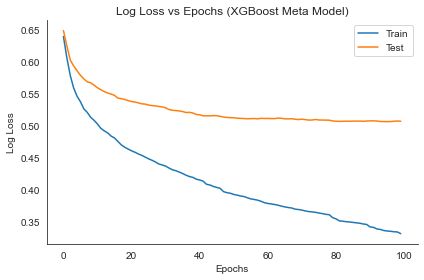

In [137]:
# Loss
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

# plot log loss
f, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
sns.despine(f, ax)
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("Log Loss vs Epochs (XGBoost Meta Model)")

f.tight_layout()
fig_name = "svc_meta_xgb_loss.png"
f.savefig(f"assets/{fig_name}", dpi=150);

In [ ]:
# Feature importance
# how it is calculated: https://stats.stackexchange.com/a/422480/311774
N_feats = 10
feat_imp = pd.Series(
    xgb_clf.feature_importances_, index=X_train.columns, name="imp"
).nlargest(N_feats)

f, ax = plt.subplots()
ax.bar(feat_imp.index, feat_imp)
sns.despine(f, ax, bottom=True)
plt.setp(ax.get_xticklabels(), rotation=75)

ax.set_xlabel("Feature Name")
ax.set_ylabel("Importance")
ax.set_title(f"Importance vs Feature for the {N_feats} Largest Importances")
f.tight_layout()
fig_name = "svc_meta_xgb_imp.png"
f.savefig(f"assets/{fig_name}", dpi=150);